In [5]:
from collections import Counter
import json
import os
import random
import re
import string
from glob import glob
from typing import Any, Dict, List, Tuple, Union

from nltk.lm import MLE, KneserNeyInterpolated, Laplace, WittenBellInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline
from tqdm import tqdm
import spacy
import utils


In [6]:
# Type define
Model = Union[MLE, Laplace, KneserNeyInterpolated, WittenBellInterpolated]

# Rules define
PUNCTUATON = set(string.punctuation)
PUNCTUATON.remove('_')

EXCEPTION_DOT = {"a.m.", "p.m.", "e.g.",
                 "mr.", "ms.", "mrs.", "dr.", "st.", "u.s."}

# Global Variable
assert spacy.prefer_gpu(), "Cannot run with gpu"
NLP = spacy.load('en_core_web_sm', disable=["tok2vec", "ner", "textcat"])

# Dubug Variable
DEBUG_ALL_ZERO = 0

In [ ]:
def LoadRawJson() -> List[dict]:
    print("- Start Loading Jsons")
    src = glob(os.path.join("./hw3/train", "*.json"))
    raw: List[dict] = []
    with tqdm(total=len(src)) as pbar:
        for file in src:
            with open(file, 'r') as F:
                data: dict = json.load(F)
                raw.append(data)
            pbar.update(1)
    return raw


In [ ]:

def TrainTestSplit(dataset: List[dict], test_size: Union[int, float] = 0.1, seed: int = None) -> Tuple[list, list]:
    random.seed(seed)
    size: int = 0
    if isinstance(test_size, int):
        assert test_size <= len(dataset), "test_size <= len(dataset)"
        size = test_size
    elif isinstance(test_size, float):
        assert test_size < 1.0, "0 <= test_size <= 1"
        size = int(len(dataset)*test_size)
    idxs = list(range(len(dataset)))
    test_set_idx = random.choices(idxs, k=size)
    train_set_idx = list(set(idxs)-set(test_set_idx))

    train_set = [dataset[i] for i in train_set_idx]
    test_set = [dataset[i] for i in test_set_idx]

    return train_set, test_set

In [ ]:
def ResolveTrainingSet(dataset: List[dict]) -> List[List[str]]:
    training_set: List[List[str]] = []
    for data in dataset:
        result: str = data["article"]
        answers: List[str] = [data["answers"][_]
                              for _ in data["answers"]]
        options: List[str] = [''] * len(answers)
        for i, [(_, v), ans] in enumerate(zip(data["options"].items(), answers)):
            options[i] = v[ord(ans)-ord('A')]
        for op in options:
            result = result.replace(" _ ", " {} ".format(op), 1)
        training_set.append(result)
    return training_set


In [ ]:
def ResolveTestingSet(dataset: List[dict]) -> Tuple[List[Dict[str, str]], Dict[str, str]]:
    '''
    Return (list of {articles,options}, answers)
    '''
    testing_set: List[Dict[str, str]] = []
    answers_set: Dict[str, str] = {}
    for data in dataset:
        answers: Dict[str, str] = data["answers"]
        options: List[Dict[str, List[str]]] = data["options"]
        answers_set = {**answers_set, **answers}
        testing_set.append({
            "article": data["article"],
            "options": options
        })
    return testing_set, answers_set

In [ ]:
def preprocess(context: str) -> List[List[Union[str, Any]]]:
    '''
    prepocess text for tokenizing
    '''
    # TODO : 先對context做去除所有符號和數字並且保留符號 ' , . _ -和空格
    # TODO : 刪掉兩個 . 以上的
    # TODO : 刪掉兩個 - 以上的
    # TODO : 刪除前綴和後綴的-
    # TODO : 由於有些字母依然會包含 . 所沒有在EXCEPTION_DOT中的要做split把點去掉
    result: List[List[Union[str, Any]]] = []
    context = re.sub('\d+', " ", context)
    context = re.sub(r"[^\w' ,._-]", " ", context)
    context = re.sub(r'(\.){2,}', ' ', context)
    context = re.sub(r'(-){2,}', ' ', context)
    context = context.lstrip('-')
    context = context.rstrip('-')
    docs = NLP(context)
    for sent in docs.sents:
        tkn = [x.lemma_.lower() for x in sent if (not x.is_space)
               and (not x.lower_ in PUNCTUATON) and (not x.is_stop)]
        clean: List[str] = []
        for dirty in tkn:
            if dirty in EXCEPTION_DOT:
                clean.append(dirty)
            else:
                for d in dirty.split('.'):
                    if len(d) > 0:
                        clean.append(d)
        result.append(clean)
    return result

In [ ]:

def Tokenizer(contexts: List[str]) -> List[List[str]]:
    '''
    contexts is a list of paragraphs
    '''
    print("- Start Tokenize")
    tknz_texts = []
    with tqdm(total=len(contexts)) as pbar:
        for context in contexts:
            pbar.update(1)
            tokenized_text = preprocess(context)
            tknz_texts.extend(tokenized_text)
    return tknz_texts

In [ ]:
def Train(n_gram: int, tknz: List[List[str]], model: Union[str, Model] = "MLE", **kwargs) -> Model:
    assert model in ["MLE", "Laplace", "KneserNeyInterpolated",
                     "WittenBellInterpolated"] or model in [MLE, Laplace, KneserNeyInterpolated, WittenBellInterpolated], "undefined model type"
    print("- Start Padding")
    train_data, padded_sents = padded_everygram_pipeline(n_gram, tknz)
    print("- Start Training with model {}".format(model))
    basic_model: Model
    if model == "MLE" or model == MLE:
        basic_model = MLE(n_gram, **kwargs)
    elif model == "Laplace" or model == Laplace:
        basic_model = Laplace(n_gram, **kwargs)
    elif model == "KneserNeyInterpolated" or model == KneserNeyInterpolated:
        basic_model = KneserNeyInterpolated(ngram, **kwargs)
    elif model == "WittenBellInterpolated" or model == WittenBellInterpolated:
        basic_model = WittenBellInterpolated(ngram, **kwargs)
    basic_model.fit(train_data, padded_sents)
    return basic_model

In [ ]:
def Prediction(model: Model, n_gram: int, dataset: List[dict],) -> Dict[str, str]:
    print("- Start Prediction")
    answer_dict: Dict[str, str] = {}
    with tqdm(total=len(dataset)) as pbar:
        for question in dataset:
            start_row: int = 0
            start_idx: int = 0
            article_token = preprocess(question["article"])
            for (ques_num, ops) in question["options"].items():
                argmax_i, start_row, start_idx = getMaximumScore(
                    model, n_gram, start_row, start_idx, article_token, ops)
                answer_dict[ques_num] = chr(argmax_i+ord('A'))
                start_idx += 1
            pbar.update(1)
    return answer_dict

In [ ]:

def getMaximumScore(model: Model, max_ngram: int, start_row: int, start_idx: int, article_token: List[List[Union[str, Any]]], ops: List[str]) -> Tuple[int, int]:
    '''
    return (argmax element,new start_row, new start_idx)
    NOTE: the article_token will be modified
    '''
    global DEBUG_ALL_ZERO
    idx: int = start_idx
    row: int = start_row
    while True:
        try:
            idx = article_token[row].index("_", idx)
            break
        except:
            idx = 0
            row += 1
    scores: List[int] = [0] * len(ops)
    for i, op in enumerate(ops):
        subset: List[str] = article_token[row][max(0, idx-max_ngram+1):idx]
        assert len(subset) <= max_ngram-1, "lenght of subset({}) needs to be equal to or less than max_ngram-1({})".format(
            len(subset), max_ngram-1)
        # Perform lemmatize on each option
        lemma_op = NLP(op)[0].lemma_.lower()
        score = model.score(lemma_op, subset)
        scores[i] = (score)

    if all(s == 0 for s in scores):
        DEBUG_ALL_ZERO += 1

    argmax_i, _ = utils.argmax(scores)
    article_token[row][idx] = ops[argmax_i]
    return argmax_i, row, idx


In [ ]:
def Evaluation(pred: Dict[str, str], actual: Dict[str, str]):
    '''
    Display evaluation matrix

    Return
    -------
    - accuracy
    - precision
    - recall
    - f1_score
    '''
    assert len(pred) == len(actual), "length of two input must be same"
    labels = ord(max(max(pred.values()), max(actual.values())))-ord('A')+1
    metric = [[0]*labels for _ in range(labels)]
    # Compute confusion matrix by metric[actual][pred]
    for k, v in pred.items():
        metric[ord(actual[k])-ord('A')][ord(v)-ord('A')] += 1
    # Internal variables
    correct_elem: List[float] = [metric[i][i] for i in range(labels)]
    actual_elem: List[float] = [sum(metric[i]) for i in range(labels)]
    pred_elem: List[float] = [sum(x) for x in zip(*metric)]
    # Compute accuracy
    # Compute precision (預測A而且正確的/所有預測是A的)
    # Compute recall (預測A而且正確的/所有真正是A的)
    accuracy: float = round(sum(correct_elem)/len(pred), 4)
    precision: List[float] = [round(correct_elem[i]/pred_elem[i], 2) if pred_elem[i] != 0 else "NaN"
                              for i in range(labels)]
    recall: List[float] = [round(correct_elem[i]/actual_elem[i], 2) if actual_elem[i] != 0 else "NaN"
                           for i in range(labels)]
    f1_score: List[float] = [round(2*precision[i]*recall[i]/(precision[i]+recall[i]), 2)
                             if precision[i]+recall[i] != 0 else "NaN" for i in range(labels)]
    print("====================================")
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall    : {}".format(recall))
    print("F1-Score  : {}".format(f1_score))
    print("Confusion Matrix:")
    for i in range(labels+1):
        if i == 0:
            print("{:<7s}".format(''), end='')
        else:
            print("{:<7s}".format(chr(i-1+ord('A'))+'?'), end='')
    print()
    for a in range(labels):
        print("{:<7s}".format(chr(a + ord('A'))), end='')
        for p in range(labels):
            print("{:<7d}".format(metric[a][p]), end='')
        print()
    print("All zero rate: {}".format(DEBUG_ALL_ZERO))
    print("====================================")
    return accuracy, precision, recall, f1_score

In [ ]:
def Solve(model: Model, n_gram: int, path: str = "result.csv") -> Dict[str, str]:
    dataset: List[dict] = []
    test_list = glob(os.path.join("./hw3/test", "*.json"))
    print("- Start Solving")
    for file in test_list:
        with open(file, 'r') as F:
            question: dict = json.load(F)
            dataset.append(question)
    answer_dict = Prediction(model, n_gram, dataset)
    utils.dict_writer(answer_dict, path)
    return answer_dict

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def DrawBar(counter:Counter,length:int=10):
    arr = counter.most_common(length)
    key = [x[0] for x in arr]
    val = [x[1] for x in arr]
    x = np.arange(len(arr))
    plt.bar(x, val)
    plt.xticks(x, key)
    plt.xlabel('Words')
    plt.ylabel('Freq')
    plt.title('Word Frequecy without stopwords')

In [8]:
def Analysis(path: str):
    '''
    Find top ten words with/without stop words
    '''
    model: Model = utils.load_pkl(path)
    DrawBar(model.vocab.counts)

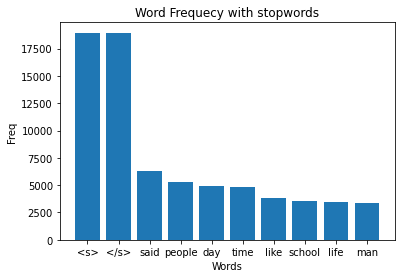

In [10]:
Analysis("hw3\model\generate_WittenBellInterpolated_nostop.pkl")